Script produzido para cálculo de onda de projeto para dimensionar obras costeiras a partir de dados de ondas (ondógrafos) e informações da maré.

In [112]:
## Seção de imports
import pandas as pd
import numpy as np
from google.colab import drive
from numpy.core.fromnumeric import mean
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy as sp
import math
!pip install reliability
import reliability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1 - Organização dos dados

In [113]:
## CARREGAMENTO DOS DADOS DE ONDA
'''
Rede Ondas https://redeondas.furg.br/ (2021). Rede de Propagação de Ondas em Águas Rasas.
Dados oriundos do Projeto PIC-Online, Universidade Federal de Santa Catarina, UFSC.
Coordenação, Universidade Federal de Rio Grande, FURG.
Dado com medição a cada 30min
'''
# mounting your google drive in the colab environment
drive.mount('/content/drive')

dframe = pd.read_csv('/content/drive/My Drive/Intertidal_Zones/Ondas/Floripa.csv',
                     header = 0,
                      sep = ';',
                      usecols = ['Hs','Tp','Dp']
                      )
#print (dframe)

# ORGANIZAÇÃO DAS ALTURAS
H_ordenado = sorted(dframe['Hs'])
#print(H_ordenado)

# CÁLCULO DE Hs E DEFINIÇÃO DE LIMIAR
print('tamanho do dado:', len(H_ordenado)//3)
C = len(H_ordenado)
Hs = mean(H_ordenado[:C])
print('Hs =', Hs)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
tamanho do dado: 700
Hs = 1.9370252260828178


# 2 - TRATAMENTO DOS DADOS

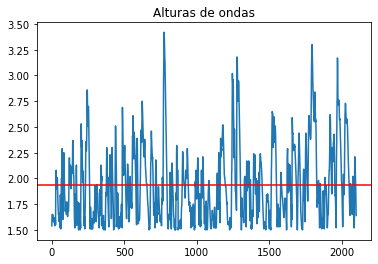

In [114]:
plt.plot(dframe['Hs'])
plt.title('Alturas de ondas')
plt.axhline(y = Hs, color = 'r', linestyle = '-') 
plt.show()


Como podem aparecer mais de um valor superior ao limiar em um mesmo período, poderiam ser considerados referentes a uma mesma tempestade. 
Então, para se considerar a independência dos eventos, foi estipulado um período de X dias (você pode modificar de acordo com sua região)

O número de eventos extremos (H(t)>Hs) na séries temporal é:  549
   


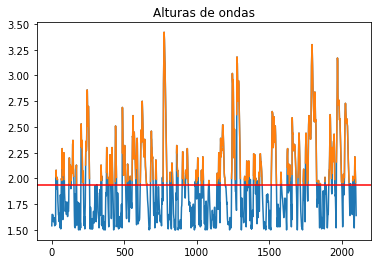

In [115]:
# CONSIDERAR INDEPENDENCIA TEMPORAL --> 7 DIAS?
# a cada 7 dias, pegar os valores maiores que Hs
extremo = np.arange(len(dframe['Hs']),dtype=float)
extremo_plt = np.empty((len( dframe['Hs'] ))) # essa aqui é só pra fazer um plot
extremo_plt.fill(np.nan)
Hss_dep=[]
for i in range(len(dframe['Hs'])): # iteração para identificar se o evento é maior que Hs ou não
  #print(dframe['Hs'].iloc[i])
  if np.isnan(dframe['Hs'].iloc[i]):
    extremo = dframe['Hs'][i]
  elif dframe['Hs'].iloc[i]<(Hs):
    extremo[i]=0 # quanto 'extremo' for igual a zero, o evento não é extremo
  elif dframe['Hs'].iloc[i]>=(Hs):
    extremo[i]=1 # quanto 'extremo' for igual a 1, o evento é extremo
    extremo_plt[i] = dframe['Hs'].iloc[i]
    Hss_dep.append(dframe['Hs'][i])

extremo_independete = np.zeros(np.shape(Hss_dep),dtype=float) # Criando o vetor que vai indicar a ocorrência do evento independente e o número do evento
out=[] # lista auxiliar da função
counta=1 # contador para auxiliar a função
for i in range(1,len(extremo)): # esta iteração vai criar um vetor que identifica o inicio e o fim dos eventos extremos, eventos acima do limiar
  if extremo[i]==1:  
    out.append([i-counta-1,i-1])
    counta+=1 # o out é a lista que identifica o inicio e o fim dos eventos acima do limiar-> out[[inicio, fim],[incio,fim]]

count=0
Hss=[]
#print(len(out))
for i in range(1,len(out)): # esta iteração vai verificar se o início do evento i+1 tem intervalo de 7 dias do fim do evento i
  if out[i][1]-out[i-1][0]>=(7*24*2):
    count+=1 # (7*24*2) -> se seus dados tem frequencia amostral de 30', isto é igual ao periodo de 7 dias 
    np.put(extremo_independete, # o 'extremo_independete' é pra ser o seu resultado final. extremo_independete>1 indica ocorrencia de evento
           count,
           np.arange(out[i][1],out[i-1][0])
           )
    Hss.append(Hss_dep[i])
    
print('O número de eventos extremos (H(t)>Hs) na séries temporal é: ', count) #número de eventos independentes
print('   ')
plt.plot(dframe['Hs'])
plt.plot(extremo_plt)
plt.title('Alturas de ondas')
plt.axhline(y = Hs, color = 'r', linestyle = '-') 
#plt.legend()
plt.show()
#print((Hss))
# GERAR TABELA DE DISTRIBUIÇÃO POR CLASSES

# 3 - PROBABILIDADES

In [150]:
# FORMA MANUAL, AINDA NÃO CONCLUÍDA

Hss_ordenado = sorted(Hss)
at = np.max(Hss_ordenado) - np.min(Hss_ordenado)
'''
Lembrando que k = raiz quadrada do total de registros/amostras
k = math.sqrt(len(Hss_ordenado))
# O valor de amplitude de classe pode ser arredondado para um número inteiro, geralmente para facilitar a interpretação da tabela.
h = at/k 
h = math.ceil(h)
'''
h=0.25
frequencias = []

# Menor valor da série
menor = round(np.min(Hss_ordenado),1)

# Menor valor somado a amplitude
menor_amp = round(menor+h,1)

valor = menor
while valor < np.max(Hss_ordenado):
    frequencias.append('{} - {}'.format(round(valor,1),round(valor+h,1)))
    valor += h

freq_abs = pd.qcut(Hss_ordenado,len(frequencias),labels=frequencias) # Discretização dos valores em k faixas, rotuladas pela lista criada anteriormente
classes = [1.9, 2.2, 2.4, 2.6, 2.9, 3.2, 3.4]
classes_m = [2.05, 2.3, 2.5, 2.75, 3.05, 3.3]

print(freq_abs)

['1.9 - 2.2', '1.9 - 2.2', '1.9 - 2.2', '1.9 - 2.2', '1.9 - 2.2', ..., '3.2 - 3.4', '3.2 - 3.4', '3.2 - 3.4', '3.2 - 3.4', '3.2 - 3.4']
Length: 549
Categories (6, object): ['1.9 - 2.2' < '2.2 - 2.4' < '2.4 - 2.6' < '2.6 - 2.9' < '2.9 - 3.2' < '3.2 - 3.4']


"\nfrom reliability.Probability_plotting import Weibull_probability_plot, plot_points, plotting_positions,Exponential_probability_plot, Exponential_probability_plot_Weibull_Scale\nfrom reliability.Fitters import Fit_Weibull_2P\nplt.subplot(122)\nWeibull_probability_plot(failures=Hss) #cumulative distribution function\nfit = Fit_Weibull_2P(failures=Hss)\nplot_points(failures=Hss, color='black', marker='^', s=50)\nplt.legend()\nplt.show()\n"

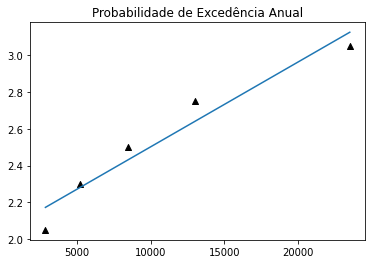

In [182]:
frequencia = pd.value_counts(pd.cut(x = Hss_ordenado, bins = classes, labels=frequencias, include_lowest = True))
percent = pd.value_counts(pd.cut(x = Hss_ordenado, bins = classes, labels = frequencias, include_lowest = True), normalize = True )

probab_classes = pd.DataFrame({'Frequencia': frequencia, 'Porcentagem': percent})
probab_classes

probab_classes['Frequencia acumluada'] = pd.DataFrame.cumsum(probab_classes['Frequencia'])
soma = sum(probab_classes['Frequencia'])
probab_classes['P'] = probab_classes['Frequencia acumluada']/soma
probab_classes['Q'] = 1- probab_classes['P']

probab_classes['Probabilidade Excedencia'] = -(np.log(probab_classes['Q']))

# NS = (EE por ano, em média)
NS = len(Hss)/((len(dframe['Hs'])/(2*24*30*12))) # 12*24*30*12 = período em anos dos dados 
Qs = probab_classes['Probabilidade Excedencia']*NS

#plt.subplot(121)
plt.title('Probabilidade de Excedência Anual')
plt.scatter(Qs,classes_m, marker='^', color = 'black')

Qs = Qs.iloc[:-1] 
classes_2 = [2.05, 2.3, 2.5, 2.75, 3.05]

a, b = np.polyfit(Qs,classes_2, 1) #find line of best fit
plt.plot(Qs, a*Qs+b) #add line of best fit to plot

# VISUALIZAR DISTRIBUIÇÃO DE WEIBULL
'''
from reliability.Probability_plotting import Weibull_probability_plot, plot_points, plotting_positions,Exponential_probability_plot, Exponential_probability_plot_Weibull_Scale
from reliability.Fitters import Fit_Weibull_2P
plt.subplot(122)
Weibull_probability_plot(failures=Hss) #cumulative distribution function
fit = Fit_Weibull_2P(failures=Hss)
plot_points(failures=Hss, color='black', marker='^', s=50)
plt.legend()
plt.show()
'''

# 4 - ONDA DE PROJETO

   
Altura da onda de projeto: 2.041764800166078
   


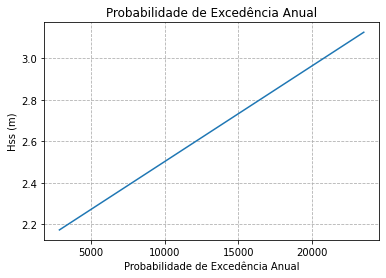

In [178]:
# EXTENDE-SE ESSA RETA PARA O TEMPO DE RETORNO DA ONDA DESEJADO
# 𝐻𝑠𝑠 = −𝐴 ln(𝑄) + 𝐵
# da distribuição de weibul
# A = 1.77
# B = 6.79

# AJUSTAR UMA RETA AX+B COM OS VALORES ENCONTRADOS
A = a
B = b
y = (A*Qs)+B

plt.grid(linestyle = '--')
plt.plot(Qs,y) 
plt.title('Probabilidade de Excedência Anual')
plt.xlabel('Probabilidade de Excedência Anual')
plt.ylabel('Hss (m)')

from math import log
# TR = VIDA ÚTIL DA OBRA = 15 anos
# Calculo de acordo com equação
X = -log((1/15)/NS)
Hproj = A*X + B
print('   ')
print("Altura da onda de projeto:", Hproj)
print('   ')
